# Environment Import

In [3]:
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, expr, col, collect_list, udf, explode, split
from pyspark.sql.types import ArrayType, FloatType

# Part 1: Init Spark Session with Ratings

In [4]:
def init_spark_session_with_ratings():
    """
    Reads the ratings file and returns the SparkSession and DataFrame created from the file.

    Returns:
    SparkSession, DataFrame: The Spark session and the DataFrame created from the ratings file.
    """

    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("MovieRecommend") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "4") \
        .config("spark.driver.memory", "16G") \
        .getOrCreate()

    ratings_df = spark.read.csv("dataset/ratings.csv", header=True, inferSchema=True)
    print(ratings_df)
    ratings_df.show()

    return spark, ratings_df


spark, ratings_df = init_spark_session_with_ratings()

23/12/02 08:25:45 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 192.168.102.123 instead (on interface ens192)
23/12/02 08:25:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 08:25:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrame[userId: int, movieId: int, rating: double, timestamp: int]
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



In [7]:
def other_data_analysis(ratings_df):
    # Calculate the average rating for each movie
    avg_rating_df = ratings_df.groupBy("movieId").agg(avg("rating").alias("avg_rating"))
    filtered_movies_df = avg_rating_df.filter(col("avg_rating") == 5)

    # Load the movies data
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)

    # Join the two DataFrames
    joined_df = filtered_movies_df.join(movies_df, "movieId")
    split_genres_df = joined_df.withColumn("genres", split(col("genres"), "\\|"))

    # Explode the genres into rows
    exploded_df = split_genres_df.select("title", explode("genres").alias("genre"))

    # Group by genre and count the number of movies in each category
    cleaned_df = exploded_df.groupBy("genre").agg(collect_list("title").alias("movies"))
    cleaned_data = {
        "genres": []
    }
    for row in cleaned_df.collect():
        genre_data = {
            "genre": row["genre"],
            "scoreGT5Count": len(row["movies"]),
            "movie": row["movies"]
        }
        cleaned_data["genres"].append(genre_data)
    json_data = json.dumps(cleaned_data, ensure_ascii=False, indent=4)

    # Save the results to a JSON file
    with open("results/other_data_analysis.json", "w") as file:
        file.write(json_data)


other_data_analysis(ratings_df)

# Part 2: Basic Recommend with Visualization

In [3]:
def basic_recommend(spark, ratings_df):
    """
    Performs basic movie recommendation based on the average rating.

    Args:
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Compute the average rating for each movie
    avg_ratings_df = ratings_df.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

    # Join with the movies DataFrame to get the movie titles and genres
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    joined_df = avg_ratings_df.join(movies_df, "movieId").withColumn("genres", split(col("genres"), "\\|"))

    # Join with the tags DataFrame to get the movie tags, and aggregate tags into a single string for each movie
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
    joined_df = joined_df.join(tags_df, "movieId").withColumn("tag", col("tag")). \
        groupBy("movieId", "title", "genres", "avg_rating"). \
        agg(expr("concat('[', concat_ws(', ', collect_list(tag)), ']')").alias("tags")
            )

    # Retrieve top 5 movies based on average ratings
    top_movies = joined_df.orderBy(col("avg_rating"), ascending=False).limit(5)
    top_movies.show()

    return top_movies


top_movies = basic_recommend(spark, ratings_df)

+-------+--------------------+--------------------+----------+--------------------+
|movieId|               title|              genres|avg_rating|                tags|
+-------+--------------------+--------------------+----------+--------------------+
| 127080|The Diary of Pres...|    [Drama, Romance]|       5.0|  [independent film]|
| 136988|The Good Mistress...|             [Drama]|       5.0|          [tv movie]|
| 124987|   Snow White (1987)|          [Children]|       5.0|[fairy tale, home...|
| 147615|The Battle of Lov...|[(no genres listed)]|       5.0|[Troma Entertainm...|
| 133307|Time Zero: The La...|       [Documentary]|       5.0|          [business]|
+-------+--------------------+--------------------+----------+--------------------+



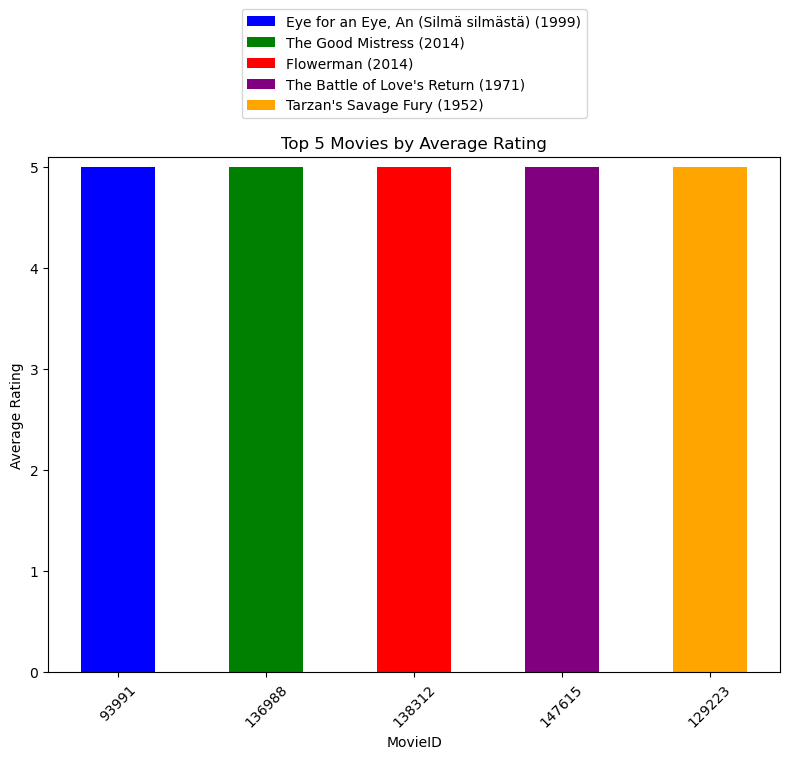

In [4]:
def basic_recommend_visualization(top_movies):
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    top_movies_pd = top_movies.toPandas()

    # Define colors for each movie (you can customize this)
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot each movie as a separate bar
    for i, row in enumerate(top_movies_pd.itertuples(), start=1):
        movie_id = row.movieId
        movie_title = row.title
        avg_rating = row.avg_rating  # Use the column name 'avg_rating'
        color = colors[i - 1]

        # Plot the bar with the movie title as label
        ax.bar(str(movie_id), avg_rating, width=0.5, color=color, label=movie_title)

    # Set labels and title
    ax.set_xlabel('MovieID')
    ax.set_ylabel('Average Rating')
    ax.set_title('Top 5 Movies by Average Rating')

    # Ensure that the top of the bars are within the visible range of the plot
    plt.ylim(0, 5.1)

    # Rotate movie titles for better visibility
    plt.xticks(rotation=45)

    # Add a legend to explain the colors
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Close the plt object to free memory
    plt.close()


basic_recommend_visualization(top_movies)

# Part3: ALS Recommend with Visualization

## 3.1 Optimal Parameters Chosen

In [5]:
def als_recommend(ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares).

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Create an ALS model
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

    # Define a grid of parameters for tuning
    param_grid = {
        "rank": [10, 20],
        "maxIter": [5, 10],
        "regParam": [0.01, 0.1]
    }

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Variables to keep track of the best model and its performance
    best_rmse = float('inf')
    best_error = float('inf')
    best_params = None
    results = []

    # Grid search through the parameter space
    for rank in param_grid["rank"]:
        for max_iter in param_grid["maxIter"]:
            for reg_param in param_grid["regParam"]:
                start_time = time.time()

                # Set model parameters
                als.setParams(rank=rank, maxIter=max_iter, regParam=reg_param)

                # Fit ALS model on training data
                model = als.fit(training)

                # Evaluate the model on test data
                predictions = model.transform(test)
                rmse = rmse_evaluator.evaluate(predictions)
                mae = mae_evaluator.evaluate(predictions)
                training_time = time.time() - start_time

                # Append results
                results.append({
                    "rank": rank, "maxIter": max_iter, "regParam": reg_param,
                    "RMSE": rmse, "MAE": mae, "Training Time": training_time
                })

                # Update best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (rank, max_iter, reg_param)

    # Save the results DataFrame to a CSV file
    results_df = pd.DataFrame(results)
    print(results_df)

    # Display the best model parameters and its RMSE
    print("Best Parameters:", best_params)
    print("Best RMSE:", best_error)


als_recommend(ratings_df)

23/11/30 07:39:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


   rank  maxIter  regParam      RMSE       MAE  Training Time
0    10        5      0.01  0.829486  0.638148      47.777165
1    10        5      0.10  0.826285  0.645126      40.870306
2    10       10      0.01  0.810260  0.618900      51.412874
3    10       10      0.10  0.814018  0.631412      49.845394
4    20        5      0.01  0.825468  0.629510      52.075976
5    20        5      0.10  0.829962  0.651692      49.523931
6    20       10      0.01  0.817938  0.620012      67.369276
7    20       10      0.10  0.811837  0.631145      67.318704
Best Parameters: (10, 10, 0.01)
Best RMSE: inf


## 3.2 ALS Recommend With Optimal Parameters

In [6]:
def als_recommend_best(ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares) model with optimal parameters.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Create an ALS model
    als = ALS(rank=10, maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
              coldStartStrategy="drop")

    # Fit ALS model on training data
    model = als.fit(training)

    # Evaluate the model on test data
    predictions = model.transform(test)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Generate top 5 movie recommendations for each user using the best model
    recommendations = model.recommendForAllUsers(5)
    recommendations.show(truncate=False)

    return recommendations


recommendations = als_recommend_best(ratings_df)

23/11/30 07:46:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Square Error (RMSE): 0.8072171300756796
Mean Absolute Error (MAE): 0.6111281587996001


+------+--------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                         |
+------+--------------------------------------------------------------------------------------------------------+
|31    |[{174403, 6.057178}, {116935, 5.828315}, {126749, 5.7715116}, {136880, 5.447052}, {148859, 5.2071157}]  |
|34    |[{170113, 11.136791}, {112577, 9.995285}, {49872, 9.944384}, {5154, 9.926613}, {133569, 9.79133}]       |
|53    |[{84996, 11.503202}, {198657, 10.026142}, {174403, 9.710598}, {41704, 9.625774}, {167532, 9.444785}]    |
|65    |[{147354, 15.017892}, {134117, 14.216842}, {149130, 13.8547}, {176999, 13.626796}, {26611, 13.5799885}] |
|78    |[{26968, 10.760106}, {162006, 9.259368}, {112577, 9.147092}, {119754, 8.7132635}, {147236, 8.678355}]   |
|85    |[{135585, 11.549908}, {125938, 11.525369}, {183875, 11.525028}, {133325, 10.7987

In [7]:
def als_recommend_visualization(recommendations):
    recs_exploded = recommendations. \
        withColumn("rec_exp", explode("recommendations")). \
        select("userId", col("rec_exp.movieId"), col("rec_exp.rating"))
    recs_exploded.show()

    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    recs_joined = recs_exploded.join(movies_df, "movieId").select("userId", "title", "rating")
    recs_pd = recs_joined.toPandas()

    # Count the number of recommendations for each movie and get the top 5
    top_movies = recs_pd['title'].value_counts().head(5)

    # Plotting the number of times each movie is recommended using the movie titles
    plt.figure(figsize=(12, 8))
    top_movies.plot(kind='bar')
    plt.xlabel('Movie Title')  # Changed from 'Movie ID' to 'Movie Title'
    plt.ylabel('Number of Recommendations')
    plt.title('Top 5 Recommended Movies by ALS Model')
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust the layout to fit the labels
    plt.show()
    plt.close()


als_recommend_visualization(recommendations)

+------+-------+----------+
|userId|movieId|    rating|
+------+-------+----------+
|    31| 174403|  6.057178|
|    31| 116935|  5.828315|
|    31| 126749| 5.7715116|
|    31| 136880|  5.447052|
|    31| 148859| 5.2071157|
|    34| 170113| 11.136791|
|    34| 112577|  9.995285|
|    34|  49872|  9.944384|
|    34|   5154|  9.926613|
|    34| 133569|   9.79133|
|    53|  84996| 11.503202|
|    53| 198657| 10.026142|
|    53| 174403|  9.710598|
|    53|  41704|  9.625774|
|    53| 167532|  9.444785|
|    65| 147354| 15.017892|
|    65| 134117| 14.216842|
|    65| 149130|   13.8547|
|    65| 176999| 13.626796|
|    65|  26611|13.5799885|
+------+-------+----------+
only showing top 20 rows



# Part 4: RF Recommend with Visualization

In [ ]:
def feature_engineering(spark, ratings_df):
    # relevance 
    genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)
    take_top_n_udf = udf(lambda arr: sorted(arr, reverse=True)[:20], ArrayType(FloatType()))
    genome_scores_df = genome_scores_df.groupby('movieId').agg(
        take_top_n_udf(collect_list('relevance')).alias('relevance_list')
    )
    genome_scores_df = genome_scores_df.orderBy('movieId')
    genome_scores_df.show(truncate=False)

    # genre
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))
    movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))

    genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
    indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
    genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
    encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)

    genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))

    sum_vectors_udf = udf(lambda vectors: Vectors.dense(np.sum([v.toArray() for v in vectors], axis=0)), VectorUDT())
    genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))
    genre_aggregated.show(truncate=False)

    # tag
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
    genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)
    tags_df = tags_df.join(genome_tags_df, tags_df.tag == genome_tags_df.tag, "inner").select(tags_df["*"])

    tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
    tag_model = tag_indexer.fit(genome_tags_df)
    indexed_tags_df = tag_model.transform(tags_df)
    tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
    tag_encoder_model = tag_encoder.fit(indexed_tags_df)
    tags_encoded = tag_encoder_model.transform(indexed_tags_df)

    movie_tags_features = tags_encoded.groupBy('movieId').agg(collect_list('tagVec').alias('tagVectors'))
    sum_vectors_udf = udf(lambda vectors: Vectors.dense(np.sum([v.toArray() for v in vectors], axis=0)), VectorUDT())
    movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors'))
    movie_tags_features = movie_tags_features.drop("tagVectors")
    movie_tags_features.show(truncate=False)

    # join
    complete_data_df = ratings_df.join(genre_aggregated.select("movieId", "genresVec"), "movieId") \
        .join(movie_tags_features.select("movieId", "tagFeatures"), "movieId") \
        .join(genome_scores_df.select('movieId', 'relevance_list'), 'movieId', 'left')
    complete_data_df = complete_data_df.orderBy('userId')
    complete_data_df.show(truncate=False)

    return complete_data_df


complete_data_df = feature_engineering(spark, ratings_df)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movieId|relevance_list                                                                                                                                                                |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1      |[0.99925, 0.99875, 0.99575, 0.98575, 0.98425, 0.98, 0.9645, 0.95975, 0.95475, 0.94725, 0.93675, 0.92875, 0.91625, 0.90725, 0.90375, 0.89625, 0.89375, 0.893, 0.88575, 0.87625]|
|2      |[0.976, 0.959, 0.95175, 0.95, 0.932, 0.9185, 0.879, 0.87075, 0.8685, 0.86725, 0.8495, 0.8175, 0.8145, 0.77525, 0.75375, 0.73975, 0.73225, 0.72675, 0.705, 0.6965]             |
|3      |[0.97525, 0.9625, 0.9305, 0.853, 0.75425, 0.6765, 0.6445, 0.578, 0

+-------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|movieId|genreVecList                                                                       |genresVec                                                                    |
+-------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|1      |[(19,[9],[1.0]), (19,[12],[1.0]), (19,[11],[1.0]), (19,[1],[1.0]), (19,[14],[1.0])]|[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|2      |[(19,[9],[1.0]), (19,[11],[1.0]), (19,[14],[1.0])]                                 |[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|3      |[(19,[1],[1.0]), (19,[3],[1.0])]                                                   |[0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+-------+------+------+----------+-----------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def rf_train_evaluate(data_ready):
    """
    Train, evaluate, and visualize movie recommendations using a Random Forest model.

    Args:
    data_ready (DataFrame): DataFrame containing prepared features for training.
    """

    # Splitting the dataset
    training_features, test_features = data_ready.randomSplit([0.7, 0.3])

    # Training the Random Forest model with optimized parameters
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="rating",
        numTrees=5,  # 减少树的数量以加快训练
        maxDepth=5,  # 降低树的最大深度
        maxBins=32,
        minInstancesPerNode=1  # 每个节点的最小实例数
    )
    model = rf.fit(training_features)

    # Evaluate model on test dataset
    predictions_df = model.transform(test_features)
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Calculate and output evaluation metrics
    rmse = rmse_evaluator.evaluate(predictions_df)
    mae = mae_evaluator.evaluate(predictions_df)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    return predictions_df


predictions_df = rf_train_evaluate(complete_data_df)
predictions_df.show()

Root Mean Square Error (RMSE): 0.9951233309228193
Mean Absolute Error (MAE): 0.786046399092221


+-------+------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|movieId|userId|rating| timestamp|           genresVec|         tagFeatures|      relevance_list|    relevance_vector|            features|        prediction|
+-------+------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|      7|   122|   4.0| 848692767|[0.0,1.0,0.0,1.0,...|[0.0,0.0,0.0,0.0,...|[0.98125, 0.96225...|[0.98124998807907...|(1166,[1,3,127,21...|3.1588841802775653|
|     47|   155|   4.0|1196554584|[0.0,0.0,1.0,0.0,...|[0.0,0.0,0.0,0.0,...|[0.99375, 0.98525...|[0.99374997615814...|(1166,[2,13,104,1...| 4.033920122685735|
|    160|  1164|   2.0| 842549804|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[0.98625, 0.977, ...|[0.98624998331069...|(1166,[4,9,10,13,...|  3.03986986390674|
|    173|   983|   1.5|1078585598|[0.0,0.0,0.0

23/12/02 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on

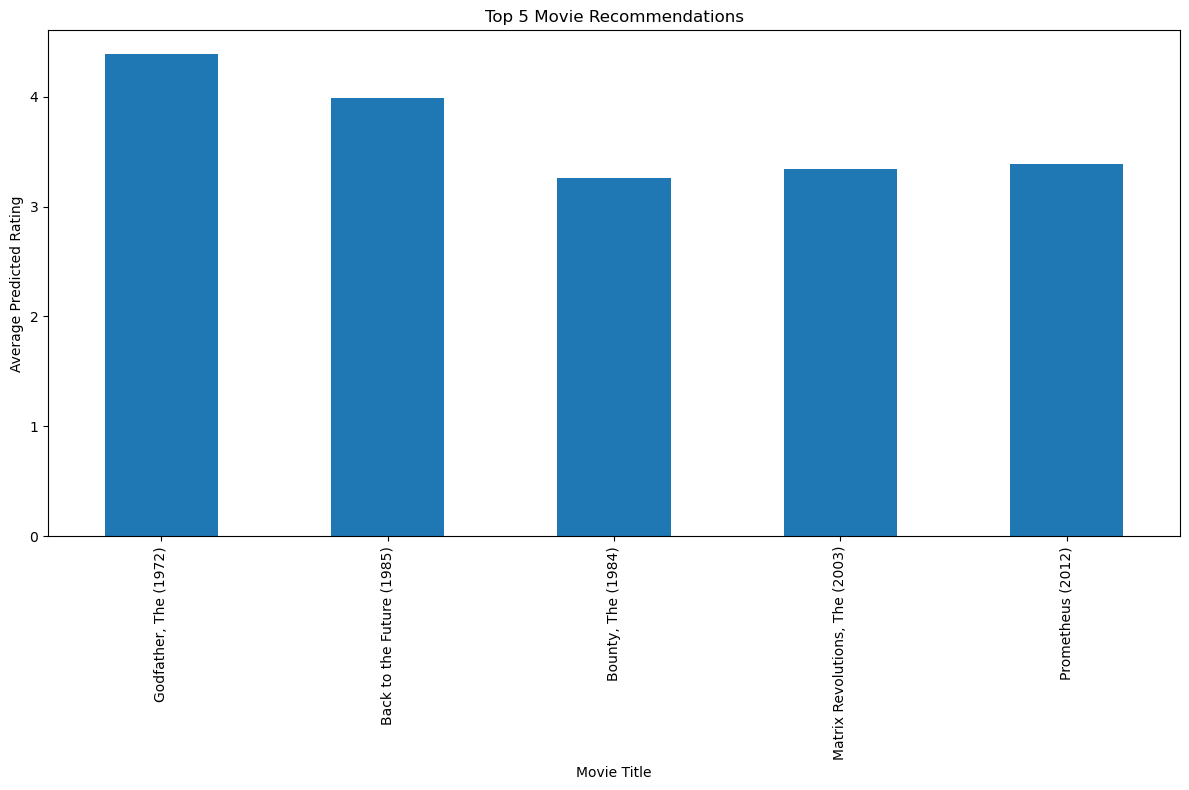

In [ ]:
def rf_recommend_visualization(predictions_df):
    top_predictions = predictions_df. \
        groupBy('movieId').agg({'prediction': 'avg'}). \
        withColumnRenamed('avg(prediction)', 'average_rating').limit(5)

    # Join with the movies dataframe to get movie titles
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
    top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title',
                                                                               'average_rating')  # Use 'average_rating' here

    # Convert to pandas dataframe for visualization
    top_movies_pd = top_movies_with_titles.toPandas()
    top_movies_pd.set_index('title', inplace=True)

    # Plot
    plt.figure(figsize=(12, 8))
    top_movies_pd['average_rating'].plot(kind='bar')  # Use 'average_rating' here
    plt.xlabel('Movie Title')
    plt.ylabel('Average Predicted Rating')  # Update the ylabel
    plt.title('Top 5 Movie Recommendations')
    plt.tight_layout()
    plt.show()
    plt.close()


rf_recommend_visualization(predictions_df)

# Part 5: Model Comparison

**ALS model**:
+ Advantages: It is suitable for large-scale data sets, can effectively handle sparsity problems, and is often used in recommendation systems.
+ Disadvantages: Need to adjust multiple parameters, sensitive to cold start issues.

**Random forest model**:
+ Advantages: It handles nonlinear relationships well and is less prone to overfitting.
+ Disadvantages: A large amount of feature engineering is required and the computational cost is high.